<a href="https://colab.research.google.com/github/emimorgan97/Machine-Learning-Final-Project/blob/main/Resize_NMF_Pad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.decomposition import NMF
import gzip
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
def display_images(images_data, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        normalized_image = images_data[i] / 255.0 if images_data[i].max() > 1 else images_data[i]
        axes[i].imshow(images_data[i])
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")
    plt.show()

In [ ]:
# Paths to gzip-compressed HDF5 files
images_file_path = '/content/drive/MyDrive/ML_Data/pcamv1/camelyonpatch_level_2_split_train_x.h5.gz'
labels_file_path = '/content/drive/MyDrive/ML_Data/pcamv1/camelyonpatch_level_2_split_train_y.h5.gz'

# Number of images to read in each batch
chunk_size = 50

# Initialize lists to store data
images_data = []
labels_data = []

# Open gzip-compressed HDF5 files and read data in chunks
with gzip.open(images_file_path, 'rb') as f_images, h5py.File(f_images, 'r') as hf_images:
    with gzip.open(labels_file_path, 'rb') as f_labels, h5py.File(f_labels, 'r') as hf_labels:
        num_images = 10000  # set this depending on how many images you want

        for i in range(0, num_images, chunk_size):
            # Read chunk of image data
            images_chunk = hf_images['x'][i:i+chunk_size]
            images_data.extend(images_chunk)

            # Read corresponding chunk of labels data
            labels_chunk = hf_labels['y'][i:i+chunk_size]
            labels_data.extend(labels_chunk)

# Now you have images_data and labels_data containing the data of images and labels, respectively, in chunks.
# You can further process this data as needed.


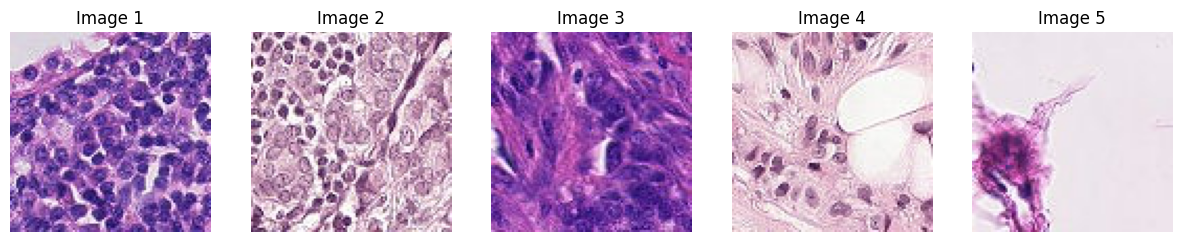

In [ ]:
display_images(images_data[:5], 5)

In [ ]:
def resize_to_center(image_data, target_size=(32, 32)):
    # Get original image size
    original_size = image_data.shape[:2]
    # Calculate top-left position for the new image
    top = (original_size[0] - target_size[0]) // 2
    left = (original_size[1] - target_size[1]) // 2
    # Crop the original image to the center
    cropped_image = image_data[top:top+target_size[0], left:left+target_size[1], :]
    return cropped_image

# Number of images to process
num_images = len(images_data)  # Assuming images_data contains all the image data

# Resize each image to center 32x32 pixels
resized_images = []
for image_data in images_data:
    resized_image_data = resize_to_center(image_data)
    resized_images.append(resized_image_data)

# Now you have resized_images containing the resized image data.
# You can further process this data as needed.


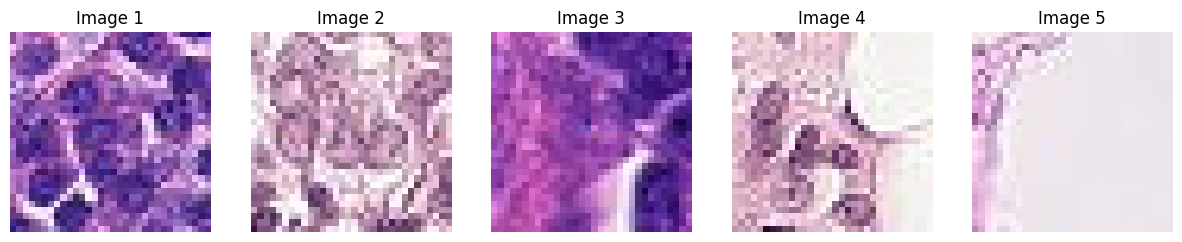

In [ ]:
# Visualize 5 resized images
display_images(resized_images[:5], 5)

In [ ]:
resized_images_array = np.array(resized_images)

# Normalize pixel values to [0, 1] range
normalized_images = resized_images_array / 255.0

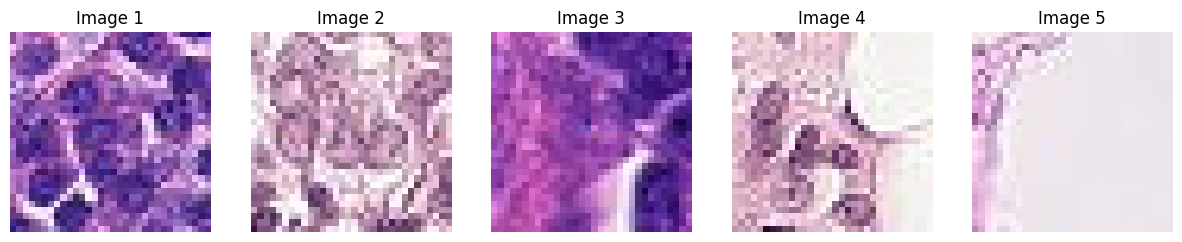

In [ ]:
display_images(normalized_images, 5)

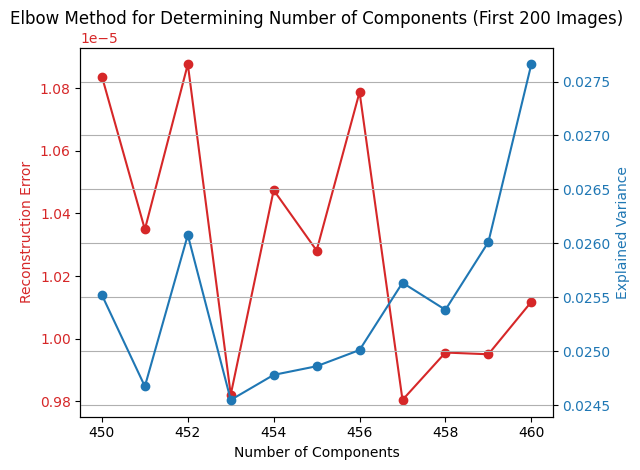

In [ ]:
#given that we need the same set of components for class 0 and class 1 data, we are just going to be looking at the first 200 images, regardless of what class they are to figure out how many components we should have for

# Set number of images to extract
num_images = 100

# Get subset of those images
subset_images = np.array(normalized_images[:num_images])

# List to store the reconstruction errors and explained variance
reconstruction_errors = []
explained_variances = []

# Maximum number of components to try
min_components = 450
max_components = 460


#Since structure is not clear with images, initializing it with nnsvd would make it so that it would always reach max iter without converging
#random has a better chance, because structure is not clear, there aren't clear patterns etc.
#with n_components 30, the explained variance was .007, with the reconstruction erros .03 which is absolutely horrible, this is why we are plotting from 30 to 100
# Iterate over different numbers of components
for n_components in range(min_components, max_components + 1):
    # Initialize NMF model
    nmf_model = NMF(n_components=n_components, max_iter=500, tol=2e-3, init='random')

    # Fit the model and transform the data
    nmf_transformed = nmf_model.fit_transform(subset_images.reshape(num_images, -1))

    # Reconstruct the data
    reconstructed_images = np.dot(nmf_transformed, nmf_model.components_)

    # Calculate reconstruction error (Mean Squared Error)
    mse = np.mean((subset_images.reshape(num_images, -1) - reconstructed_images) ** 2)

    # Append the reconstruction error to the list
    reconstruction_errors.append(mse)

    # Calculate explained variance
    explained_variance = np.sum(nmf_transformed ** 2) / np.sum(subset_images.reshape(num_images, -1) ** 2)

    # Append the explained variance to the list
    explained_variances.append(explained_variance)

# Plot both the reconstruction errors and explained variances as a function of the number of components
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Reconstruction Error', color=color)
ax1.plot(range(min_components, max_components + 1), reconstruction_errors, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Explained Variance', color=color)
ax2.plot(range(min_components, max_components + 1), explained_variances, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method for Determining Number of Components (First 200 Images)')
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.decomposition import NMF
import numpy as np

# Assuming labels_data is a list/array containing labels (0s and 1s)
# and resized_images is a list/array containing corresponding images

# Convert data to numpy arrays for easier manipulation
labels_data = np.array(labels_data)
resized_images = np.array(normalized_images)

# Define the number of components for NMF
n_components = 50  # You can adjust this number based on your requirements

# Initialize NMF model
nmf_model = NMF(n_components=n_components, max_iter=500, tol=2e-3, init='random')

# Initialize lists to store reconstructed images and corresponding labels
reconstructed_images = []
reconstructed_labels = []

# Iterate over unique labels
for label in np.unique(labels_data):
    # Get indices of images with the current label
    label_indices = np.where(labels_data == label)[0]

    # Batch size for processing images
    batch_size = 100  # You can adjust this based on your memory constraints

    # Iterate over batches of images with the current label
    for i in range(0, len(label_indices), batch_size):
        batch_indices = label_indices[i:i+batch_size]
        batch_images = resized_images[batch_indices]

        # Reshape the batch of images to flatten them
        batch_images_flattened = batch_images.reshape(len(batch_indices), -1)

        # Apply NMF to the batch of images
        nmf_transformed = nmf_model.fit_transform(batch_images_flattened)

        # Reconstruct the original images
        reconstructed_batch = np.dot(nmf_transformed, nmf_model.components_)

        # Append reconstructed images and labels
        reconstructed_images.extend(reconstructed_batch)
        reconstructed_labels.extend([label] * len(batch_indices))

# Convert reconstructed images and labels to numpy arrays
reconstructed_images = np.array(reconstructed_images)
reconstructed_labels = np.array(reconstructed_labels)

# Reshape the reconstructed images to match the original shape
reconstructed_images = reconstructed_images.reshape(normalized_images.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

In [ ]:
shuffled_indices = np.random.permutation(len(reconstructed_images))
reconstructed_images = reconstructed_images[shuffled_indices]
reconstructed_labels = reconstructed_labels[shuffled_indices]

In [ ]:
def min_max_normalize(image_data):
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

min_max_normalize(reconstructed_images)

array([[[[0.35650304, 0.25600533, 0.36959424],
         [0.41392562, 0.28738596, 0.40556241],
         [0.33938388, 0.20532144, 0.30499468],
         ...,
         [0.34381647, 0.280716  , 0.33831491],
         [0.56561955, 0.51882334, 0.56787736],
         [0.60799968, 0.55156099, 0.60387171]],

        [[0.44485586, 0.32112482, 0.43012617],
         [0.36796458, 0.23433322, 0.3460763 ],
         [0.46668564, 0.30271221, 0.41582878],
         ...,
         [0.39646426, 0.33770011, 0.39156005],
         [0.56093588, 0.51437835, 0.55463287],
         [0.50972291, 0.45233812, 0.50172314]],

        [[0.4165939 , 0.32027569, 0.39181331],
         [0.31130331, 0.17062348, 0.25173773],
         [0.53716363, 0.38017818, 0.46400749],
         ...,
         [0.58061518, 0.5116222 , 0.5697307 ],
         [0.46868276, 0.42454159, 0.45892927],
         [0.37162249, 0.30125831, 0.36079096]],

        ...,

        [[0.62506819, 0.51637127, 0.59342282],
         [0.71970592, 0.63074459, 0.70744603]

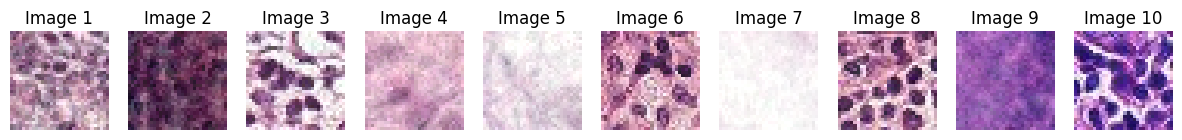

In [ ]:
display_images(reconstructed_images[:10], 10)

In [ ]:
# Function to pad images to be of size 96x96
def pad_images(images_data, target_size=(96, 96)):
    padded_images = []
    for image_data in images_data:
        # Calculate padding amounts for each dimension
        pad_height = max(target_size[0] - image_data.shape[0], 0)
        pad_width = max(target_size[1] - image_data.shape[1], 0)

        # Pad the image with zeros
        padded_image = np.pad(image_data, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_images.append(padded_image)
    return padded_images

# Pad resized images to be of size 96x96
padded_images = pad_images(reconstructed_images)

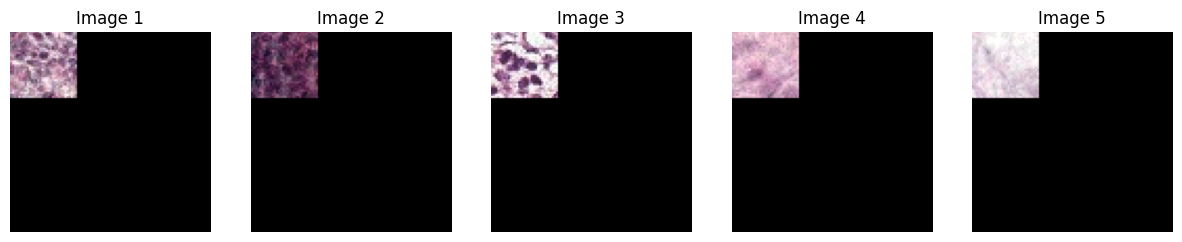

In [ ]:
display_images(padded_images[:5],5)

In [ ]:
import h5py
import gzip

# Paths for the output HDF5 and gzip files for images and labels
output_images_h5_file_path = '50_padded_NMF.h5'
output_labels_h5_file_path = '50_labels_NMF.h5'
output_images_h5_gz_file_path = '50_padded_NMF.h5.gz'
output_labels_h5_gz_file_path = '50_labels_NMF.h5.gz'

# Create HDF5 file to store padded images
with h5py.File(output_images_h5_file_path, 'w') as output_images_file:
    # Create a dataset to store padded images
    output_images_dataset = output_images_file.create_dataset('images', data=padded_images)

# Create HDF5 file to store labels
with h5py.File(output_labels_h5_file_path, 'w') as output_labels_file:
    # Create a dataset to store labels
    output_labels_dataset = output_labels_file.create_dataset('labels', data=labels_data)

# Gzip the HDF5 file for images
with open(output_images_h5_file_path, 'rb') as f_in:
    with gzip.open(output_images_h5_gz_file_path, 'wb') as f_out:
        f_out.writelines(f_in)

# Gzip the HDF5 file for labels
with open(output_labels_h5_file_path, 'rb') as f_in:
    with gzip.open(output_labels_h5_gz_file_path, 'wb') as f_out:
        f_out.writelines(f_in)

print("Padded images and labels saved to HDF5 files and gzip compressed successfully.")

Padded images and labels saved to HDF5 files and gzip compressed successfully.


In [ ]:
import shutil
destination_drive_path = '/content/drive/MyDrive/Training Data: Subset 10000 Images'
shutil.copy(output_images_h5_gz_file_path, destination_drive_path)
shutil.copy(output_labels_h5_gz_file_path, destination_drive_path)

'/content/drive/MyDrive/Training Data: Subset 10000 Images/50_labels_NMF.h5.gz'